## Model training

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
import imp
import utils; imp.reload(utils) 
from utils import plot_batch
from utils import Vgg16BN

Using TensorFlow backend.


In [7]:
data_path="../data/"
train_dir="/train"
val_dir="/val"
int_test_dir="/int_test"
ext_test_dir="/ext_test" 
project_name="statefarm"
project_data_path=data_path+project_name
train_data_path=project_data_path+train_dir
val_data_path=project_data_path+val_dir
int_test_data_path=project_data_path+int_test_dir
ext_test_data_path=project_data_path+ext_test_dir
weights_file = project_data_path+'/statefarm.h5'

In [3]:
idg = IDG()

In [4]:
classes = ["".join("c"+str(n)) for n in range(0,10)]
classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [5]:
class_mode = 'categorical'
batch_size = 32
train_gen = idg.flow_from_directory(train_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_gen = idg.flow_from_directory(val_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 13462 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [15]:
num_of_samples = len(train_gen.filenames)
print(num_of_samples)

13462


In [16]:
train_batch, train_labels = train_gen.next()
val_batch, val_labels = val_gen.next()

In [17]:
print(train_data_path)
print(val_data_path)
print(classes)

../data/statefarm/train
../data/statefarm/val
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


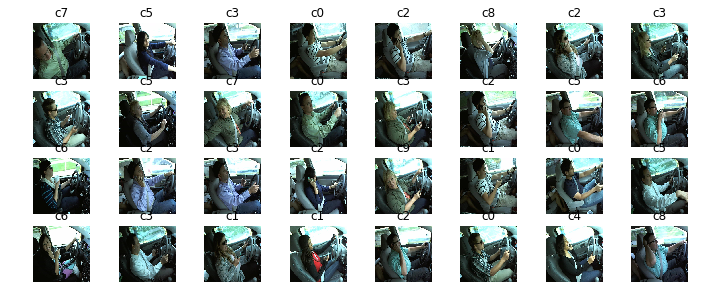

In [18]:
plot_batch(val_batch, val_labels, classes)

In [19]:
print(train_batch.shape)
print(val_batch.shape)

(32, 256, 256, 3)
(32, 256, 256, 3)


In [20]:
from keras.applications.vgg16 import VGG16

In [21]:
image_shape = train_batch.shape[1:]
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=image_shape, pooling=None)

In [22]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [23]:
from keras.layers import Flatten, Dense
from keras.models import Model

vgg16_top = vgg16_base.output
vgg16_top = Flatten()(vgg16_top)
# let's add a fully-connected layer
vgg16_top = Dense(1024, activation='relu')(vgg16_top)
# and a logistic layer -- let's say we have 2 classes
vgg16_top = Dense(10, activation='softmax')(vgg16_top)

# this is the model we will train
model = Model(inputs=vgg16_base.input, outputs=vgg16_top)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [6]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

NameError: name 'model' is not defined

In [26]:
train_gen = idg.flow_from_directory(train_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_gen = idg.flow_from_directory(val_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 13462 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [27]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
num_batches = num_of_samples/batch_size
epochs = 10
steps_per_epoch = batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', period=1)

# fine-tune the model
model.fit_generator(train_gen, steps_per_epoch=num_batches, epochs=epochs, 
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    validation_data=val_gen, validation_steps=10) 

Epoch 1/10
421/420 [==============================] - 196s - loss: 13.3571 - acc: 0.1672 - val_loss: 11.6751 - val_acc: 0.2719
Epoch 2/10
421/420 [==============================] - 191s - loss: 10.4717 - acc: 0.3454 - val_loss: 10.3576 - val_acc: 0.3469
Epoch 3/10
421/420 [==============================] - 190s - loss: 9.0697 - acc: 0.4310 - val_loss: 8.0358 - val_acc: 0.4938
Epoch 4/10
421/420 [==============================] - 190s - loss: 7.4260 - acc: 0.5326 - val_loss: 6.7511 - val_acc: 0.5750
Epoch 5/10
421/420 [==============================] - 190s - loss: 6.8493 - acc: 0.5717 - val_loss: 6.6701 - val_acc: 0.5813
Epoch 6/10
421/420 [==============================] - 190s - loss: 6.7273 - acc: 0.5811 - val_loss: 6.6025 - val_acc: 0.5875
Epoch 7/10
421/420 [==============================] - 189s - loss: 6.7217 - acc: 0.5820 - val_loss: 7.0893 - val_acc: 0.5594
Epoch 8/10
421/420 [==============================] - 190s - loss: 6.7146 - acc: 0.5829 - val_loss: 7.1876 - val_acc: 0.5

In [19]:
class_mode=None
batch_size=64
steps=np.ceil(4481./batch_size)
val_gen = idg.flow_from_directory(val_data_path, batch_size=batch_size, shuffle=False, class_mode=class_mode, classes=classes)
prob_val=model.predict_generator(val_gen, steps, verbose=True)

Found 4481 images belonging to 10 classes.
71/71 [==============================] - 74s    


In [20]:
from sklearn.metrics import confusion_matrix
y_pred=np.argmax(prob_val,axis=1)
y_true=val_gen.classes
confusion_matrix(y_true,y_pred)

array([[  0,  77,  31,  48,   0,  21,   9,   0,   1, 310],
       [  0, 453,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1, 462,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 468,   0,   0,   1,   0,   0,   0],
       [  0,   1,  84, 296,   0,   4,  19,   0,  19,  42],
       [  0,   1,   0,   1,   0, 457,   1,   0,   0,   2],
       [  0,   1,   1,   0,   0,   0, 462,   0,   0,   1],
       [  0,   2,   6,   0,   0,   0,   0, 388,   2,   2],
       [  0,   0,   4,   1,   0,   0,   2,   0, 372,   3],
       [  0,   1,   3,   0,   0,   0,   1,   0,   0, 420]])

## VGG16 with batchnormalization

In [9]:
vgg16=Vgg16BN(size=(256,256,3))

In [10]:
vgg16.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 256, 256, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     147584    
__________

In [11]:
from keras import optimizers
vgg16.model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
weights_file = project_data_path+'/statefarm_bn.h5'

In [12]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
num_of_samples = len(train_gen.filenames)
num_batches = num_of_samples/batch_size
epochs = 10
steps_per_epoch = batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', period=1)

In [13]:
class_mode = 'categorical'
batch_size = 32
train_gen = idg.flow_from_directory(train_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_gen = idg.flow_from_directory(val_data_path, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 13462 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:
num_batches = num_of_samples/batch_size
epochs = 10
steps_per_epoch = batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=3, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2, verbose=0, mode='auto')
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', period=1)
vgg16.model.fit_generator(train_gen, steps_per_epoch=num_batches, epochs=epochs, 
                    callbacks=[reduce_lr, early_stopping, model_checkpoint],
                    validation_data=val_gen, validation_steps=10) 

Epoch 1/10
421/420 [==============================] - 661s - loss: 1.7054 - acc: 0.5066 - val_loss: 1.4977 - val_acc: 0.5406
Epoch 2/10
421/420 [==============================] - 648s - loss: 0.5211 - acc: 0.8324 - val_loss: 0.2182 - val_acc: 0.9313
Epoch 3/10
421/420 [==============================] - 642s - loss: 0.2800 - acc: 0.9145 - val_loss: 0.1524 - val_acc: 0.9563
Epoch 4/10
421/420 [==============================] - 643s - loss: 0.1839 - acc: 0.9413 - val_loss: 0.0504 - val_acc: 0.9844
Epoch 5/10
421/420 [==============================] - 649s - loss: 0.1271 - acc: 0.9598 - val_loss: 0.0311 - val_acc: 0.9906
Epoch 6/10
421/420 [==============================] - 635s - loss: 0.0741 - acc: 0.9776 - val_loss: 0.0615 - val_acc: 0.9781
Epoch 8/10
421/420 [==============================] - 627s - loss: 0.0651 - acc: 0.9797 - val_loss: 0.0345 - val_acc: 0.9931


In [14]:
vgg16.model.load_weights(weights_file)

In [15]:
class_mode=None
batch_size=64
steps=np.ceil(4481./batch_size)
val_gen = idg.flow_from_directory(val_data_path, batch_size=batch_size, shuffle=False, class_mode=class_mode, classes=classes)
prob_val_bn=vgg16.model.predict_generator(val_gen, steps, verbose=True)

Found 4481 images belonging to 10 classes.
71/71 [==============================] - 79s    


In [16]:
from sklearn.metrics import confusion_matrix
y_pred_bn=np.argmax(prob_val_bn,axis=1)
y_true=val_gen.classes
confusion_matrix(y_true,y_pred_bn)

array([[483,   0,   2,   9,   0,   0,   0,   1,   0,   2],
       [  0, 453,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   3, 456,   1,   1,   0,   0,   2,   0,   0],
       [  1,   0,   0, 466,   2,   0,   0,   0,   0,   0],
       [  1,   0,   1,   4, 458,   0,   0,   1,   0,   0],
       [  2,   0,   0,   2,   0, 457,   0,   0,   0,   1],
       [  0,   4,   7,   0,   1,   0, 452,   0,   1,   0],
       [  0,   1,   0,   0,   0,   0,   2, 397,   0,   0],
       [  1,   1,   5,   3,   5,   0,   7,   2, 352,   6],
       [  5,   0,   3,   1,   0,   1,   1,   1,   0, 413]])

In [17]:
test_gen=idg.flow_from_directory(ext_test_data_path, batch_size=64,
                                   class_mode=None,  # only data, no labels
                                   shuffle=False)  # keep data in same order as labels

Found 79726 images belonging to 1 classes.


In [20]:
test_dataset_size = len(test_gen.filenames)
num_of_batches = test_dataset_size/batch_size

In [21]:
prob_test_bn=vgg16.model.predict_generator(test_gen, num_of_batches, verbose=True)

1246/1245 [==============================] - 1315s  


In [22]:
prob_test_bn_clipped = prob_test_bn
prob_test_bn_clipped.shape

(79726, 10)

In [23]:

print(test_dataset_size)

79726


In [24]:
import pandas as pd
n1 = [s.split('/')[1] for s in test_gen.filenames]
# n2 = [(s.split('.')[0]) for s in n1]
results = pd.DataFrame(prob_test_bn_clipped)
temp = pd.DataFrame(np.array(n1))
results=pd.concat([temp, results],axis=1)
results.head()

,0,0,1,2,3,4,5,6,7,8,9
0,img_46339.jpg,5.199347e-05,3.281236e-05,0.001884,0.001500,0.000492,9.910320e-01,4.383707e-04,0.000425,4.136424e-03,7.952717e-06
1,img_18865.jpg,1.159507e-07,8.771667e-01,0.000038,0.012156,0.067809,2.150468e-03,4.052979e-02,0.000021,1.081403e-04,2.090742e-05
2,img_23088.jpg,1.131414e-03,5.743243e-07,0.000001,0.000039,0.000003,9.988142e-01,1.232827e-07,0.000003,9.643048e-07,7.071586e-06
3,img_92913.jpg,7.731178e-06,6.973586e-04,0.019066,0.002917,0.021448,2.133657e-04,5.037335e-01,0.007926,4.439891e-01,1.905155e-06
4,img_82508.jpg,1.319885e-09,9.604002e-06,0.000074,0.000002,0.000011,2.540226e-07,6.827580e-01,0.317024,1.211051e-04,3.813770e-09


In [25]:
results.to_csv('test.csv')

In [26]:
from IPython.display import FileLink
FileLink('test.csv')

/src/workspace/exercises/test.csv